In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr

# Extrapolation in temperature

In [3]:
#Import idealgas module
from thermoextrap import idealgas

#Define test betas and reference beta
betas = np.arange(0.1, 10.0, 0.5)
beta_ref = betas[11]
vol = 1.0

#Define orders to extrapolate to
orders = [1,2,4,6]
order = orders[-1]

npart = 1000 #Number of particles (in single configuration)
nconfig = 100_000 #Number of configurations

#Generate all the data we could want
xdata, udata = idealgas.generate_data((nconfig, npart), beta_ref, vol)

## Case 3: Observable is the negative logarithm of an average with no explicit temperature dependence

This type of extrapolation is useful for extrapolating hard-sphere chemical potentials in temperature or volume, or other quantities involving logarithms of probabilities (e.g. PMFs).

This is in fact easier than Case 2 because we do not need to augment the data in any way - we just set a flag that the quantity to extrapolate is the negative logarithm of an ensemble average, i.e., `minus_log=True`. Note, though, that we handled the -log calculation in the definition of the derivatives (even at zeroth order). This means we want to just pass data, not the -log of the data.

In [4]:
import thermoextrap as xtrap

In [9]:
#Create and train extrapolation model
xem_log = xtrap.beta.factory_extrapmodel(
    beta=beta_ref, #minus_log=True,
    data=xtrap.beta.DataCentralMomentsVals.from_vals(
        order=orders[-1], xv=xdata, uv=udata, deriv_dim=None, central=True))

#Check the parameters
print("Model parameters (derivatives):")
print(xem_log.derivs(norm=False, minus_log=True))
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(xem_log.predict(betas[:4], order=2, minus_log=True))
print('\n')

Model parameters (derivatives):
<xarray.DataArray 'x' (order: 7)>
array([  1.74359351,   0.16096861,  -0.01889249,   0.10984808,
        -0.63628153, -15.02866717, -10.92924574])
Dimensions without coordinates: order


Model predictions:
<xarray.DataArray (beta: 4)>
array([0.5725173 , 0.70259439, 0.82794835, 0.94857919])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6




In [10]:
# alternatively, use post_func
#Create and train extrapolation model
xem_log = xtrap.beta.factory_extrapmodel(
    beta=beta_ref, post_func='minus_log',
    data=xtrap.beta.DataCentralMomentsVals.from_vals(
        order=orders[-1], xv=xdata, uv=udata, deriv_dim=None, central=True))

#Check the parameters
print("Model parameters (derivatives):")
print(xem_log.derivs(norm=False))
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(xem_log.predict(betas[:4], order=2))
print('\n')

Model parameters (derivatives):
<xarray.DataArray 'x' (order: 7)>
array([  1.74359351,   0.16096861,  -0.01889249,   0.10984808,
        -0.63628153, -15.02866717, -10.92924574])
Dimensions without coordinates: order


Model predictions:
<xarray.DataArray (beta: 4)>
array([0.5725173 , 0.70259439, 0.82794835, 0.94857919])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6




In [11]:
#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(xem_log.resample(nrep=100).predict(betas[:4], order=3).std('rep'))

Bootstrapped uncertainties in predictions:


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.DataArray (beta: 4)>
array([1.85578457, 1.39684312, 1.0206036 , 0.71884773])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6


True extrapolation coefficients: [ 1.74377054e+00  1.61056939e-01 -1.77268660e-02  3.66764737e-04
  2.11140145e-03 -1.53768224e-03  3.99266294e-04]
	 With N_configs =     10: [ 1.73178756e+00  1.32358268e-01  4.87841639e-01 -1.86026213e+00
 -5.69533936e+01 -2.26334762e+02  1.15068570e+04]
	 With N_configs =    100: [ 1.74045228e+00  2.06539808e-01 -3.85762221e-01  1.99909620e+00
  3.36888076e+01 -1.22634467e+03  5.85908391e+03]
	 With N_configs =   1000: [ 1.74498780e+00  1.56342896e-01 -8.96138418e-02  8.25413759e-01
 -6.84995305e+00 -3.55443283e+01  1.71234822e+02]
	 With N_configs =  10000: [ 1.74366235e+00  1.58167011e-01 -6.48996114e-03 -6.88592053e-02
 -5.28684609e-01 -5.51189910e+01 -1.01160996e+02]
	 With N_configs = 100000: [  1.74359351   0.16096861  -0.01889249   0.10984808  -0.63628153
 -15.02866717 -10.92924574]


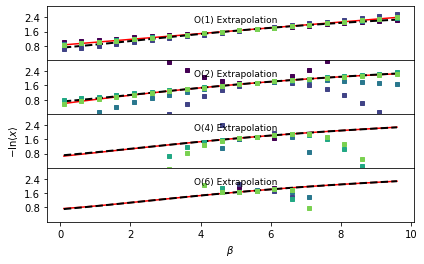

In [13]:
#Repeat comparison of results, but for -ln<x> instead of <x>

fig, ax = plt.subplots(len(orders), sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betas, -np.log(idealgas.x_ave(betas, vol)), 'k--', linewidth=2.0)

#Next look at extrapolation with an infinite number of samples
#This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(orders):
    trueExtrap, trueDerivs = idealgas.x_beta_extrap_minuslog(o, beta_ref, betas, vol)
    ax[j].plot(betas, trueExtrap, 'r-', zorder=0)
    if j == len(orders)-1:
        print('True extrapolation coefficients: {}'.format(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xem_log = xtrap.beta.factory_extrapmodel(
        beta=beta_ref, post_func='minus_log',
        data=xtrap.beta.DataCentralMomentsVals.from_vals(order=orders[-1], 
                                                  uv=udata[thisinds], 
                                                  xv=xdata[thisinds], 
                                                  central=True))
    out = xem_log.predict(betas, cumsum=True)
    print('\t With N_configs = %6i: %s'%(n, str(xem_log.derivs(norm=False).values.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(orders):
        out.sel(order=o).plot(marker='s', ms=4, color=nsampcolors[i], ls='None', label='N={}'.format(n), 
                              ax=ax[j])

ax[2].set_ylabel(r'$-\mathrm{ln} \langle x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(orders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax[0].set_ylim((0.0, 3.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

for a in ax:
    a.set_title(None)

plt.show()
